In [1]:
# yfinanceをインストール
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [3]:
# sp500の株価を取得する
start = '2012-01-01'
end = '2023-12-31'
sp500_master = yf.download(tickers='^GSPC', interval='1d', start=start, end=end)
sp500_master


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000
...,...,...,...,...,...,...
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,4754.629883,3046770000
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,4774.750000,2513910000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,4781.580078,2748450000


<Axes: title={'center': 'SP500'}, xlabel='Date'>

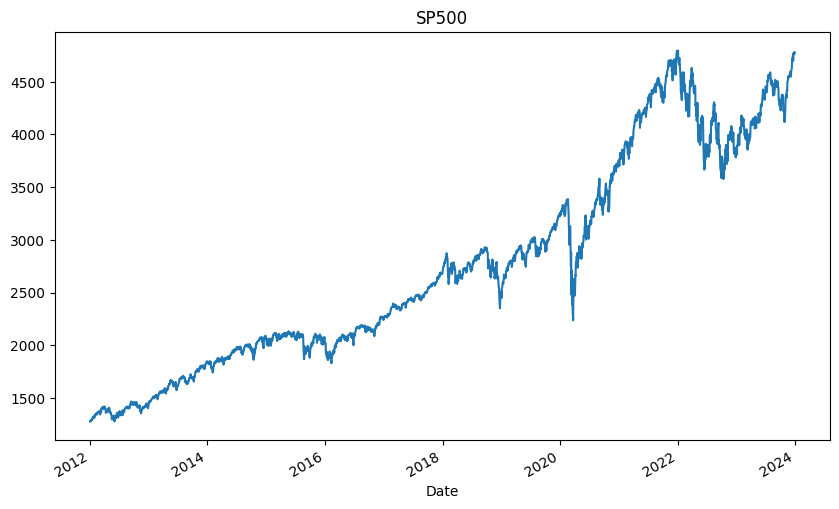

In [4]:
# グラフで確認
%matplotlib inline
from pylab import mpl, plt

sp500_master['Close'].plot(title="SP500", figsize=(10, 6))

In [5]:
# 対数収益率を計算
sp500_master['return'] = np.log(sp500_master['Close']/sp500_master['Close'].shift(1))
# 前日の各種値が翌日の終値に影響すると仮定する。
# そのため目的変数yには翌日の騰落を表すフラグを代入する。
sp500_master['y'] = np.where(sp500_master['return'] > 0, 1, 0)
sp500_master['y'] = sp500_master['y'].shift(-1)
# 確認のため騰落額もシフトする行を加える。
sp500_master['return-yest'] = sp500_master['return'].shift(-1)

# 確認ため表示
sp500_master

,Open,High,Low,Close,Adj Close,Volume,return,y,return-yest
Date,,,,,,,,,
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000,NaN,1.0,0.000188
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000,0.000188,1.0,0.002939
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000,0.002939,0.0,-0.002540
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000,-0.002540,1.0,0.002259
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000,0.002259,1.0,0.008847
...,...,...,...,...,...,...,...,...,...
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,4754.629883,3046770000,0.001659,1.0,0.004223
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,4774.750000,2513910000,0.004223,1.0,0.001429
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,4781.580078,2748450000,0.001429,1.0,0.000370


<Axes: >

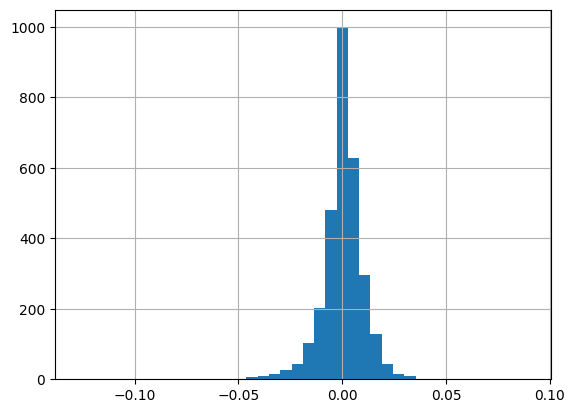

In [6]:
# ヒストグラムを表示
sp500_master['return'].hist(bins=40)

In [7]:
# 不要なカラムを削除する。
# 今回は Adj Close、return-yestを削除する。
sp500_droped = sp500_master.drop(columns=['Adj Close', 'return-yest'])

# 正解ラベルyの値は1日ずらしたため最終行のyはNaNとなる。
# そのため最終行は削除する。
sp500_droped = sp500_droped.dropna()

sp500_droped

,Open,High,Low,Close,Volume,return,y
Date,,,,,,,
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,3592580000,0.000188,1.0
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,4315950000,0.002939,0.0
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,3656830000,-0.002540,1.0
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,3371600000,0.002259,1.0
2012-01-10,1280.770020,1296.459961,1280.770020,1292.079956,4221960000,0.008847,1.0
...,...,...,...,...,...,...,...
2023-12-21,4724.290039,4748.709961,4708.350098,4746.750000,3431180000,0.010249,1.0
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,0.001659,1.0
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,0.004223,1.0


In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

data_train = sp500_droped[sp500_droped.index < '2023-01-01']
data_test = sp500_droped[sp500_droped.index >= '2023-01-01']

X_train = data_train.loc[:,['Open','High', 'Low', 'Close', 'Volume', 'return']]
X_train = sc.fit_transform(X_train)
y_train = data_train.loc[:,'y'].values

X_test = data_test.loc[:, ['Open','High', 'Low', 'Close', 'Volume', 'return']]
X_test = sc.fit_transform(X_test)
y_test = data_test.loc[:,'y'].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2767, 6)
(2767,)
(249, 6)
(249,)


In [9]:
param_grid = {
  'max_depth': [6, 7, 8],
  'learning_rate': [0.5, 0.3, 0.1],
  'n_estimators': [17,18,19],
  'reg_alpha': [0.25, 0.3, 0.35],
  'reg_lambda': [0.45, 0.5, 0.55],
}
#    'scoring': ["accuracy","precision_macro","recall_macro","f1_macro"]

model = xgb.XGBClassifier(objective="binary:logistic", eval_metric='auc')
grid_search = GridSearchCV(estimator=model, scoring="precision", param_grid=param_grid, cv=None)
grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータを取得
best_params = grid_search.best_params_
print(grid_search.best_score_)
print("Best Hyperparameters:", best_params)

0.643589340240418
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 18, 'reg_alpha': 0.35, 'reg_lambda': 0.5}


In [10]:
eval_set=[(X_train, y_train), (X_test, y_test)]
### グリッドサーチで見つけたパラメータを使用する場合
model = xgb.XGBClassifier(**best_params)

### グリッドサーチしたパラメータを使用しない場合
# model = xgb.XGBClassifier()
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', early_stopping_rounds=3)

pred = model.predict(X_test)

print(pred.shape)
pred

[0]	validation_0-auc:0.61109	validation_1-auc:0.51235
[1]	validation_0-auc:0.65851	validation_1-auc:0.51838
[2]	validation_0-auc:0.69490	validation_1-auc:0.50717
[3]	validation_0-auc:0.74481	validation_1-auc:0.50472
(249,)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0])

[[ 19  93]
 [ 19 118]]


<Axes: >

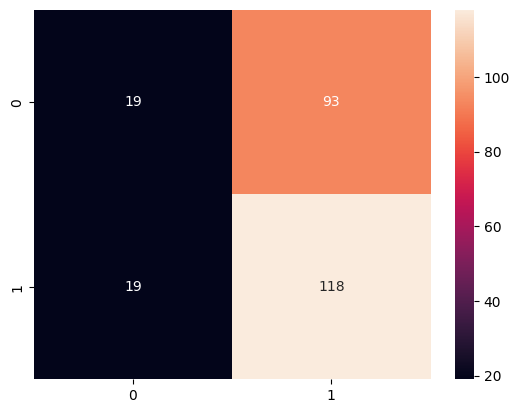

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_pred=pred, y_true=y_test)

print(cm)

sns.heatmap(cm, annot=True, fmt='d')

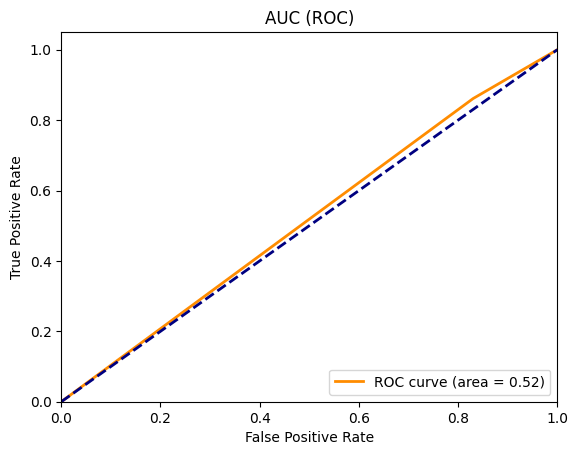

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC (ROC)')
plt.legend(loc='lower right')
plt.show()


In [13]:
# 予測結果で売買をした場合、どのような結果になるかを確認するため予測結果の0を1に置き換える。
pred = np.where(pred > 0, 1, -1)
print(pred.shape)
pred

(249,)


array([ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1, -1, -1, -1

In [14]:
data_test.loc[:,'position'] = pred
data_test
# X_test_rescale = sc.inverse_transform(X_test)
# result = pd.DataFrame(X_test_rescale, columns=['Open',	'High',	'Low', 'Close', 'Volume'])
# result

<ipython-input-14-549a33fd6d82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:,'position'] = pred


,Open,High,Low,Close,Volume,return,y,position
Date,,,,,,,,
2023-01-03,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,-0.004009,1.0,1
2023-01-04,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,0.007511,0.0,1
2023-01-05,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,-0.011714,1.0,1
2023-01-06,3823.370117,3906.189941,3809.560059,3895.080078,3923560000,0.022584,0.0,1
2023-01-09,3910.820068,3950.570068,3890.419922,3892.090088,4311770000,-0.000768,1.0,1
...,...,...,...,...,...,...,...,...
2023-12-21,4724.290039,4748.709961,4708.350098,4746.750000,3431180000,0.010249,1.0,1
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,0.001659,1.0,1
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,0.004223,1.0,1


In [15]:
data_test['strategy'] = data_test['position'].shift(1) * data_test['return']
data_test

<ipython-input-15-7e2f033b90fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['strategy'] = data_test['position'].shift(1) * data_test['return']


,Open,High,Low,Close,Volume,return,y,position,strategy
Date,,,,,,,,,
2023-01-03,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,-0.004009,1.0,1,NaN
2023-01-04,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,0.007511,0.0,1,0.007511
2023-01-05,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,-0.011714,1.0,1,-0.011714
2023-01-06,3823.370117,3906.189941,3809.560059,3895.080078,3923560000,0.022584,0.0,1,0.022584
2023-01-09,3910.820068,3950.570068,3890.419922,3892.090088,4311770000,-0.000768,1.0,1,-0.000768
...,...,...,...,...,...,...,...,...,...
2023-12-21,4724.290039,4748.709961,4708.350098,4746.750000,3431180000,0.010249,1.0,1,-0.010249
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,0.001659,1.0,1,0.001659
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,0.004223,1.0,1,0.004223


In [16]:
data_test[['return', 'strategy']].sum().apply(np.exp)

return      1.245826
strategy    1.185790
dtype: float64

,return,strategy
Date,,
2023-01-03,-0.004009,NaN
2023-01-04,0.003502,0.007511
2023-01-05,-0.008212,-0.004203
2023-01-06,0.014372,0.018381
2023-01-09,0.013604,0.017613
...,...,...
2023-12-21,0.212118,0.163469
2023-12-22,0.213777,0.165127
2023-12-26,0.217999,0.169350


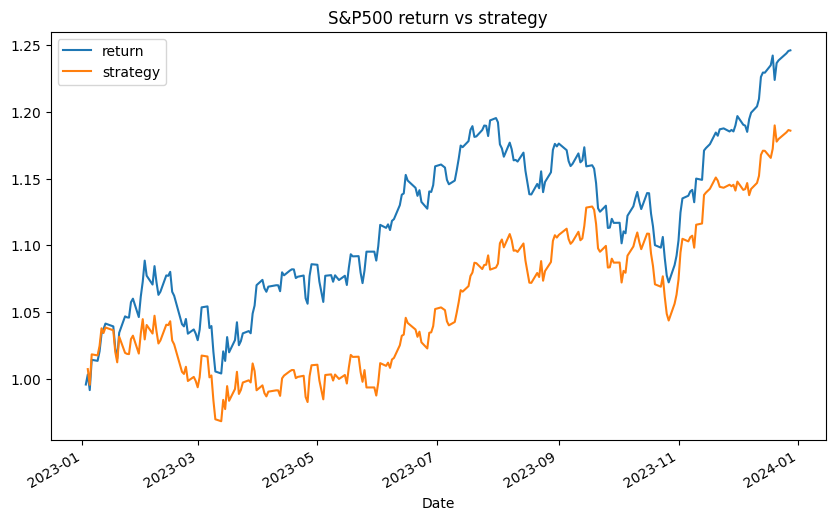

In [17]:
data_test[['return', 'strategy']].cumsum().apply(np.exp).plot(title="S&P500 return vs strategy",figsize=(10, 6))
data_test[['return', 'strategy']].cumsum()